# Zadanie 4
## Meno: Jan Balucha
## Description: Semantic segmentation of underwater images
[link to dataset](https://www.kaggle.com/datasets/ashish2001/semantic-segmentation-of-underwater-imagery-suim)

## Imports

In [1]:
!pip install wandb -qU
import wandb
wandb.login(key="e14c434d67b2b4ba6cc4249ba0c1c6e89bb444db")


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
wandb: Currently logged in as: gh0stadian. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\janba/.netrc


True

In [2]:
!pip install pytorch-lightning


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from __future__ import print_function, division

from collections import namedtuple

import torch
import os
from torch.utils.data import Dataset, DataLoader
import os
import torch
import random
import imutils
import torch.nn as nn
import torch.nn.functional as F
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
# from google.colab import drive
from torchvision import transforms, utils
from matplotlib.colors import ListedColormap
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.utils.data import random_split, DataLoader
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Callback
from pytorch_lightning.utilities.model_summary import ModelSummary
import torchvision
import random
# from torchsummary import summary
import cv2
from PIL import Image



In [5]:

test_folder = "dataset/TEST"
train_val_folder = "dataset/train_val"

assert os.path.exists(test_folder)
assert os.path.exists(train_val_folder)

In [6]:
labels = {
    "background": np.asarray((0, 0, 0)),
    "human": np.asarray((0, 0, 255)),
    "plant": np.asarray((0, 255, 0)),
    "ruin": np.asarray((0, 255, 255)),
    "robot": np.asarray((255, 0, 0)),
    "reef": np.asarray((255, 0, 255)),
    "fish": np.asarray((255, 255, 0)),
    "floor&rocks": np.asarray((255, 255, 255))
}

## Dataset and transformations

In [7]:
class UnderwaterDataset(Dataset):
    def __init__(self, root_dir, open_cv_transforms=None, merged_transforms=None, input_transforms=None, label_transforms=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.input_files_path = root_dir + "/images"
        self.label_files_path = root_dir + "/masks"

        self.input_files = os.listdir(self.input_files_path)

        self.open_cv_transforms = open_cv_transforms
        self.merged_transforms = merged_transforms
        self.input_transforms = input_transforms
        self.label_transforms = label_transforms

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input_path = os.path.join(self.input_files_path, self.input_files[idx])
        label_path = os.path.join(self.label_files_path, self.input_files[idx][:-3] + "bmp")

        # image = io.imread(input_path)
        image = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
        # label = io.imread(label_path)
        label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)
        
        if self.open_cv_transforms:
            for transf in self.open_cv_transforms:
                image, label = transf(image, label)

        if self.merged_transforms:
            image, label = self.merged_transforms((image, label))

        if self.input_transforms:
            image = self.input_transforms(image)

        if self.label_transforms:
            label = self.label_transforms(label)

        return image.float(), label.float()

In [8]:
def yuv_eq(sample, label):
    img_yuv = cv2.cvtColor(sample, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB), label

def clahe(sample, label):
    img_lab = cv2.cvtColor(sample, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    img_lab_clahe = cv2.merge((l_clahe,a,b))
    return cv2.cvtColor(img_lab_clahe, cv2.COLOR_LAB2RGB), label

def white_balance(sample, label):
    b_mean = np.mean(sample[:,:,2])
    g_mean = np.mean(sample[:,:,1])
    r_mean = np.mean(sample[:,:,0])
    
    k = (b_mean + g_mean + r_mean) / 3
    
    kb = k / b_mean
    kg = k / g_mean
    kr = k / r_mean

    sample[:,:,2] = cv2.multiply(sample[:,:,2], kb)
    sample[:,:,1] = cv2.multiply(sample[:,:,1], kg)
    sample[:,:,0] = cv2.multiply(sample[:,:,0], kr)

    return sample, label

def random_rotate(sample, label, max_degrees=30):
    degrees = random.randrange(-1 * max_degrees, max_degrees)
    sample = imutils.rotate_bound(sample, degrees)
    label = imutils.rotate_bound(label, degrees)
    return sample, label

In [9]:
class UnderwaterDatasetOpenCV(Dataset):
    def __init__(self, root_dir, open_cv_transforms=None, merged_transforms=None, input_transforms=None, label_transforms=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.input_files_path = root_dir + "/images"
        self.label_files_path = root_dir + "/masks"

        self.input_files = os.listdir(self.input_files_path)

        self.open_cv_transforms = open_cv_transforms
        self.merged_transforms = merged_transforms
        self.input_transforms = input_transforms
        self.label_transforms = label_transforms

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input_path = os.path.join(self.input_files_path, self.input_files[idx])
        label_path = os.path.join(self.label_files_path, self.input_files[idx][:-3] + "bmp")

        image = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
        label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)

        if self.open_cv_transforms:
            for transform in self.open_cv_transforms:
                image, label = transform(image, label)

        if self.input_transforms:
            image = self.input_transforms(image)

        if self.label_transforms:
            label = self.label_transforms(label)

        if self.merged_transforms:
            image, label = self.merged_transforms((image, label))
        
        # print("img", image.shape, type(image))
        # print("mask", label.shape, type(label))
        return image.float(), label.float()

In [10]:
class UnderwaterDataModule(LightningDataModule):
    def __init__(self, train_dataset, valid_dataset, test_dataset, batch_size=2):
        super().__init__()
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
    
    def prepare_data(self):
        pass
    
    def setup(self, stage = None):
        if stage == 'fit' or stage is None:
            self.train_dataset = self.train_dataset
            self.valid_dataset = self.valid_dataset

        if stage == 'test' or stage is None:
            self.test_dataset = self.test_dataset
 
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=2)
 
    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size, num_workers=2, shuffle=False)
 
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=2)

In [11]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = sample.transpose(2, 0, 1)
        return torch.from_numpy(image).float()

class EncodeMask(object):
    """Encode RGB mask to N binary images, where N is number of unique labels."""
    
    def __call__(self, sample):
        encoded_mask = []
        # print("img", sample.shape, type(sample))
        for lbl_idx, lbl_value in labels.items():
            label_mask = np.zeros(shape=(sample.shape[0],sample.shape[1]))
            mask = np.all(sample == lbl_value, axis=-1)
            label_mask[mask] = 1
            encoded_mask.append(label_mask)
        mask = np.dstack(encoded_mask)
        # fig, axes = plt.subplots(1, len(labels), figsize=(16,20))
        # for i in range(len(labels)):
        #     axes[i].imshow(mask[:, :, i]*255)
        return mask

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        mask = mask[top: top + new_h,
                    left: left + new_w]

        return image, mask

class CenterCrop(object):
    def __init__(self, output_size):
        if isinstance(output_size, int):
            output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            output_size = output_size
        self.transformer = transforms.CenterCrop(output_size)

    def __call__(self, sample):
        image, mask = sample

        image = self.transformer(image)
        mask = self.transformer(mask)

        return image, mask

# class RandomRotate(object):
#     def __init__(self, max_degrees):
#         self.max_degrees = max_degrees

#     def __call__(self, sample):
#         image, label = sample
#         degrees = random.randrange(-1 * self.max_degrees, self.max_degrees)
#         image = imutils.rotate_bound(image, degrees)
#         label = imutils.rotate_bound(label, degrees)
#         return image, label


class SimpleNormalize(object):
    """Divides input with value 255."""
    def __call__(self, sample):
        return sample / 255


## Utils

In [12]:
proportions = [0.32775785, 0.02247233, 0.02179195, 0.06817108, 0.00532479, 0.33963387, 0.07174006, 0.14310807]
weights = np.array([(1/len(proportions)) / prop for prop in proportions])
normalized_weights = (weights - min(weights)) / (max(weights) - min(weights))
normalized_weights

def dice_loss(target, prediction, eps=1e-7, weights=normalized_weights, use_weighted=False, use_softmax=True):
    prediction = torch.softmax(prediction, 1)
    reduce_axis = torch.arange(2, len(prediction.shape)).tolist()
    intersection = torch.sum(target * prediction, dim=reduce_axis)
    ground_o = torch.sum(target, dim=reduce_axis)
    pred_o = torch.sum(prediction, dim=reduce_axis)
    denominator = ground_o + pred_o
    f = 1.0 - (2.0 * intersection + eps) / (denominator + eps)
    if use_weighted and weights is not None:
        assert weights.shape[0] == f.shape[1]
        for i in range(weights.shape[0]):
            f[:, i] *= f[:, i] * weights[i]
    return torch.mean(f)

In [13]:
def focal_loss(target, input, gamma=2.0, weight=normalized_weights, use_weighted=False):
    i = input
    t = target

    # Change the shape of input and target to B x N x num_voxels.
    b, n = t.shape[:2]
    i = i.reshape(b, n, -1)
    t = t.reshape(b, n, -1)

    max_val = (-i).clamp(min=0)
    ce = i - i * t + max_val + ((-max_val).exp() + (-i - max_val).exp()).log()

    if use_weighted and weight is not None:
        class_weight = torch.as_tensor(weight)
        class_weight = class_weight.to(i)
        at = class_weight[None, :, None]
        at = at.expand((t.size(0), -1, t.size(2)))
        ce = ce * at
    
    p = F.logsigmoid(-i * (t * 2.0 - 1.0))
    flat_loss = (p * gamma).exp() * ce

    flat_loss = flat_loss.mean(dim=-1)
    loss = flat_loss.mean()
    return loss

In [14]:
def jaccard_loss(target, input, use_softmax=True, eps=1e-7):
    if use_softmax:
        input = torch.softmax(input, 1)    

    n_pred_ch = input.shape[1]
    reduce_axis = torch.arange(2, len(input.shape)).tolist()
    intersection = torch.sum(target * input, dim=reduce_axis)
    ground_o = torch.sum(target, dim=reduce_axis)
    pred_o = torch.sum(input, dim=reduce_axis)
    denominator = ground_o + pred_o
    denominator = 2.0 * (denominator - intersection)
    f = 1.0 - (2.0 * intersection + eps) / (denominator + eps)
    return torch.mean(f)

In [15]:
def wandb_mask(bg_img, pred_mask, true_mask):
  return wandb.Image(bg_img, masks={
      "prediction" : {
          "mask_data" : pred_mask, 
          "class_labels" : {idx: idx_val for idx, idx_val in enumerate(labels.keys())}
      },
      "ground truth" : {
          "mask_data" : true_mask, 
          "class_labels" : {idx: idx_val for idx, idx_val in enumerate(labels.keys())}
      }
    }
  )

class ImageLogger(Callback):
    def __init__(self, num_samples=4):
        super(ImageLogger, self).__init__()
        self.num_samples = num_samples

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if batch_idx == 0:
            # Get the model predictions for the batch
            x, y_true = batch
            y_pred = pl_module.forward(x.to(pl_module.device))
            x = x.detach().cpu().numpy().transpose(0, 2, 3, 1) * 255
            x = x.astype("uint8")
            
            y_true_img = self._get_image(y_true)
            y_pred_img = self._get_image(y_pred)


            mask_list = []
            for i in range(self.num_samples):
                mask_list.append(wandb_mask(x[i], 
                                            y_pred_img[i], 
                                            y_true_img[i]))

            wandb.log({"predictions" : mask_list})
    
    def _get_image(self, tensor):
        tensor = tensor.detach().cpu().numpy()
        shape = tensor.shape
        max_indices = np.argmax(tensor, axis=1)
        images = np.reshape(max_indices, (shape[0], shape[2], shape[3]))
        return images.astype("uint8")

## Models

### Unet

In [16]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None,kernel_size=3, padding=1, stride=2, activation="relu"):
        super().__init__()

        if not mid_channels:
          mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Dropout(p=0.1)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):

    def __init__(self, in_channels, out_channels, activation="relu"):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, activation=activation)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=2, activation="relu"):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(64, 32, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(32, out_channels, kernel_size=1),
        )

    def forward(self, x):
        return self.conv(x)

class UNetModel(nn.Module):
    def __init__(self, n_channels, n_classes, init_features=64):
        super().__init__()
        self.inc = DoubleConv(n_channels, init_features, kernel_size=3)

        # Downsample
        self.down1 = Down(init_features, init_features*2)
        self.down2 = Down(init_features*2, init_features*4)
        self.bottleneck = Down(init_features*4, init_features*8 // 2)
        
        # Upsample
        self.up1 = Up(init_features*8, init_features*4 // 2) 
        self.up2 = Up(init_features*4, init_features*2 // 2) 
        self.up3 = Up(init_features*2, init_features) 

        self.outc = OutConv(init_features, n_classes)
    
    def forward(self, x):
        x_0 = self.inc(x)

        x_1 = self.down1(x_0)
        x_2 = self.down2(x_1)
        bottleneck = self.bottleneck(x_2)
        x = self.up1(bottleneck, x_2)
        x = self.up2(x, x_1)
        x = self.up3(x, x_0)

        logits = self.outc(x)
        return logits



In [17]:
class UNet(LightningModule):
    def __init__(self, in_channels, out_channels, lr=3e-4, criterion=focal_loss, batch_size=4, init_features=64, pretrained=True, use_weighted=False):
        super(UNet, self).__init__()
        self.model = UNetModel(n_channels=in_channels, init_features=init_features, n_classes=out_channels)
        self.loss = nn.CrossEntropyLoss()
        self.criterion = criterion
        self.batch_size = batch_size
        self.lr=lr
        self.use_weighted = use_weighted

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_number):
        x, y = batch
        y = y.long()
        pred = self(x)

        loss = self.criterion(y, pred, use_weighted=self.use_weighted)
        self.log('train/loss', loss, on_epoch=True)

        self.log_metrics(y, pred, category="train")
        
        return loss
    
    def validation_step(self, batch, batch_number):
        x, y = batch
        y = y.long()

        pred = self(x)
        loss = self.criterion(y, pred, use_weighted=self.use_weighted)
        self.log('valid/loss', loss)

        self.log_metrics(y, pred, category="valid")


        
        return loss

    def test_step(self, batch, batch_number):
        x, y = batch
        y = y.long()

        pred = self(x)
        loss = self.criterion(y, pred, use_weighted=self.use_weighted)
        self.log('test/loss', loss)

        self.log_metrics(y, pred, category="test")

        return loss

    def on_validation_epoch_end(self):
        model_filename = f"model-{str(self.global_step).zfill(5)}.ckpt"
        self.trainer.save_checkpoint(model_filename)
        wandb.save(model_filename)
        self.logger.experiment.log({"global_step": self.global_step})

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

        return {
            "optimizer":optimizer,
            "lr_scheduler" : {
                "scheduler" : sch,
                "monitor" : "train/loss",
                
            }
        }
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def log_metrics(self, y, pred, category="valid"):
        jaccard = jaccard_loss(y, pred)
        self.log(f'{category}/jaccard', jaccard)

        dice = dice_loss(y, pred)
        self.log(f'{category}/dice', dice)
        

        dice_w = dice_loss(y, pred, use_weighted=True)
        self.log(f'{category}/dice_weighted', dice_w)


        focal = focal_loss(y, pred)
        self.log(f'{category}/focal', focal)

        focal_w = focal_loss(y, pred, use_weighted=True)
        self.log(f'{category}/focal_weighted', focal_w)


## RUN

In [18]:
train_critetion = focal_loss

config = {
    "model": {
        "use_pretrained_model": False,
        "init_features": 32,
        "dropout": True
    },
    "training": {
        "learning_rate": 0.01,
        "early_stopping_patience": 5,
        "criterion": "focal_loss",
        "batch_size": 16,
        "use_weighted_loss": False
    },
    "data":{
        "train_data_proportion": 0.8,
        "transformations": {
            "open_cv_transforms": "white_balance, random_rotate",
            "input": {"gausian_blur": True},
            "label": {}
        }
    },
}

In [ ]:
# MODEL

model = UNet(
    in_channels=3,
    out_channels=len(labels),
    lr=config['training']['learning_rate'],
    criterion=train_critetion,
    batch_size = config['training']['batch_size'],
    init_features=config['model']['init_features'],
    pretrained = config['model']['use_pretrained_model'],
    use_weighted = config['training']['use_weighted_loss']
)

# TRANSFORMATIONS
open_cv_transforms = [white_balance, random_rotate]
merged_transformations = transforms.Compose([CenterCrop((400,400))])
# image_transformations = transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
image_transformations = transforms.Compose([SimpleNormalize(), ToTensor(), transforms.GaussianBlur(7, sigma=(0.1, 2.0))])
label_transformations = transforms.Compose([EncodeMask(), ToTensor()])


# DATASET
# train_val_dataset = UnderwaterDataset(root_dir=train_val_folder, merged_transforms=merged_transformations, input_transforms=image_transformations, label_transforms=label_transformations)
train_val_dataset = UnderwaterDatasetOpenCV(root_dir=train_val_folder, open_cv_transforms=open_cv_transforms, merged_transforms=merged_transformations, input_transforms=image_transformations, label_transforms=label_transformations)

train_size = int(len(train_val_dataset) * config['data']['train_data_proportion'])
train_dataset, val_dataset = random_split(
    train_val_dataset,
    [train_size, len(train_val_dataset)-train_size]
)
# test_dataset = UnderwaterDataset(root_dir=test_folder, merged_transforms=merged_transformations, input_transforms=image_transformations, label_transforms=label_transformations)
test_dataset = UnderwaterDatasetOpenCV(root_dir=test_folder, open_cv_transforms=open_cv_transforms, merged_transforms=merged_transformations, input_transforms=image_transformations, label_transforms=label_transformations)

# # DATAMODULE
datamodule = UnderwaterDataModule(train_dataset, val_dataset, test_dataset, batch_size=config['training']['batch_size'])
datamodule.setup()

# # WANDB
run = wandb.init(project="Povid-4", config=config)
wandb_logger = WandbLogger(log_model=True)
wandb_logger.watch(model)

# # TRAINER
print(ModelSummary(model, max_depth=-1)) 
trainer = Trainer(
    min_epochs=100,
    callbacks=[
        LearningRateMonitor(logging_interval="step"),
        ImageLogger(4),
        ModelCheckpoint(monitor='valid/loss', mode='min')
    ],
    default_root_dir="drive/MyDrive/dataset/models",
    log_every_n_steps=50,
    logger=wandb_logger
)

trainer.fit(model, datamodule=datamodule)

wandb: Currently logged in as: gh0stadian. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


   | Name                                          | Type             | Params
------------------------------------------------------------------------------------
0  | model                                         | UNetModel        | 1.1 M 
1  | model.inc                                     | DoubleConv       | 10.2 K
2  | model.inc.double_conv                         | Sequential       | 10.2 K
3  | model.inc.double_conv.0                       | Conv2d           | 864   
4  | model.inc.double_conv.1                       | BatchNorm2d      | 64    
5  | model.inc.double_conv.2                       | GELU             | 0     
6  | model.inc.double_conv.3                       | Conv2d           | 9.2 K 
7  | model.inc.double_conv.4                       | BatchNorm2d      | 64    
8  | model.inc.double_conv.5                       | GELU             | 0     
9  | model.inc.double_conv.6                       | Dropout          | 0     
10 | model.down1                              

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | UNetModel        | 1.1 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.306     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

wandb: Network error resolved after 0:00:01.265651, resuming normal operation.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Tests

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


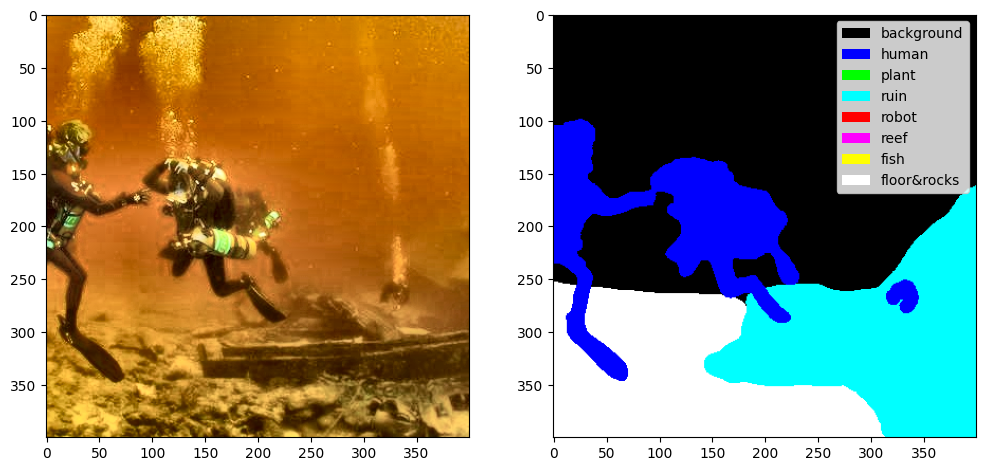

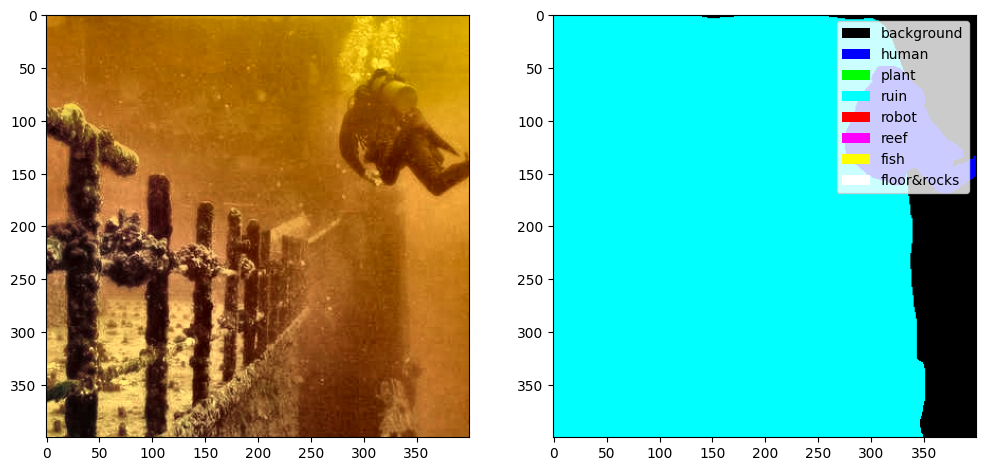

In [19]:
open_cv_transforms = [clahe]
merged_transformations = transforms.Compose([CenterCrop((400,400))])
# image_transformations = transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
image_transformations = transforms.Compose([SimpleNormalize(), ToTensor()])
label_transformations = transforms.Compose([ToTensor()])

example_dataset = UnderwaterDatasetOpenCV(root_dir=train_val_folder, open_cv_transforms=open_cv_transforms, merged_transforms=merged_transformations, input_transforms=image_transformations, label_transforms=label_transformations)
cmap = ListedColormap(['#000000', '#0000FF', '#00FF00', '#00FFFF', "#FF0000", "#FF00FF", "#FFFF00", "#FFFFFF"])

for i in range(2):
    handles = []
    for label_idx, label_name in enumerate(labels.keys()):
        handles.append(plt.Rectangle((0, 0), 1, 1, fc=cmap(label_idx)))

    image, label = example_dataset[i]
    # print("img", image.shape, type(image))
    # print("mask", label.shape, type(label))
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].imshow(image.detach().cpu().numpy().transpose(1, 2, 0))
    axes[1].imshow(label.detach().cpu().numpy().transpose(1, 2, 0))
    axes[1].legend(handles, labels.keys(), loc='best')

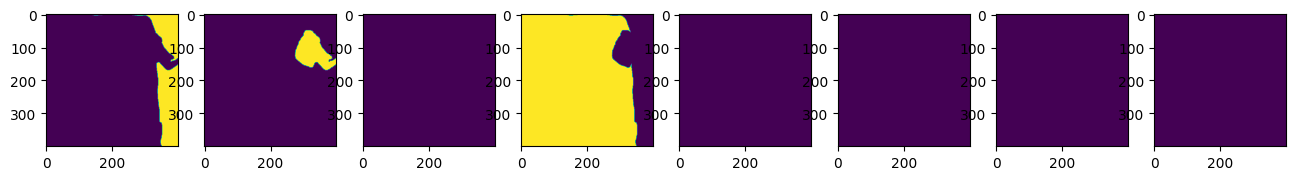

In [20]:
open_cv_transforms = [clahe]
merged_transformations = transforms.Compose([CenterCrop((400,400))])
image_transformations = transforms.Compose([SimpleNormalize(), ToTensor()])
label_transformations = transforms.Compose([EncodeMask(), ToTensor()])

# example_dataset = UnderwaterDatasetOpenCV(root_dir=train_val_folder, open_cv_transforms=open_cv_transforms, merged_transforms=merged_transformations, input_transforms=image_transformations, label_transforms=label_transformations)
example_dataset = UnderwaterDatasetOpenCV(root_dir=train_val_folder, open_cv_transforms=open_cv_transforms, merged_transforms=merged_transformations, input_transforms=image_transformations, label_transforms=label_transformations)

image, label = example_dataset[1]
label = label.detach().cpu().numpy()


fig, axes = plt.subplots(1, len(labels), figsize=(16,20))
for i in range(len(labels)):
    axes[i].imshow(label[i]*255)


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img_names = os.listdir(train_val_folder+"/images")[:3]

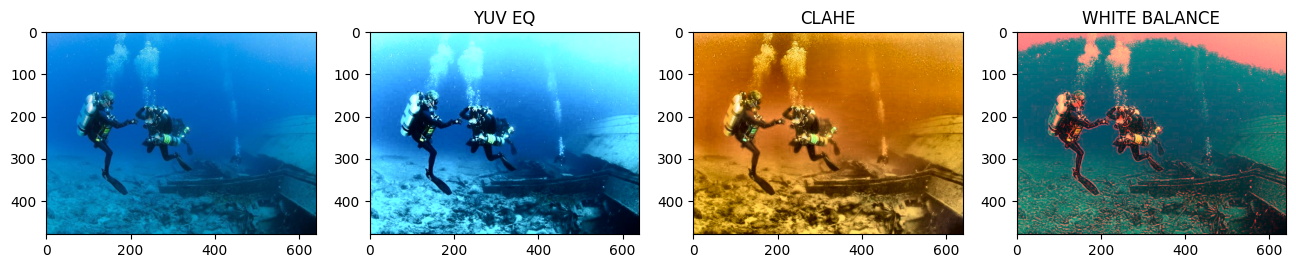

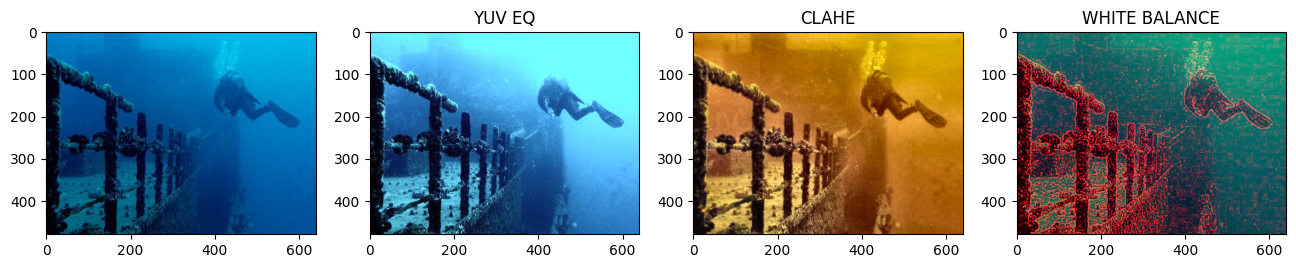

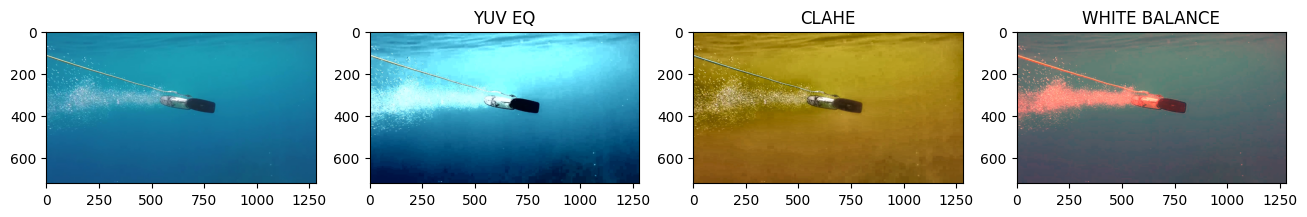

In [27]:
for img_name in img_names:
    sample = cv2.cvtColor(cv2.imread(train_val_folder + "/images/" + img_name), cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 4, figsize=(16,20))
    axes[0].imshow(sample)

    yuv, _ = yuv_eq(sample.copy(), None)
    axes[1].set_title("YUV EQ")
    axes[1].imshow(yuv)

    clahe_img, _ = clahe(sample.copy(), None)
    axes[2].set_title("CLAHE")
    axes[2].imshow(clahe_img)

    wb, _ = white_balance(sample.copy(), None)
    axes[3].set_title("WHITE BALANCE")
    axes[3].imshow(wb)

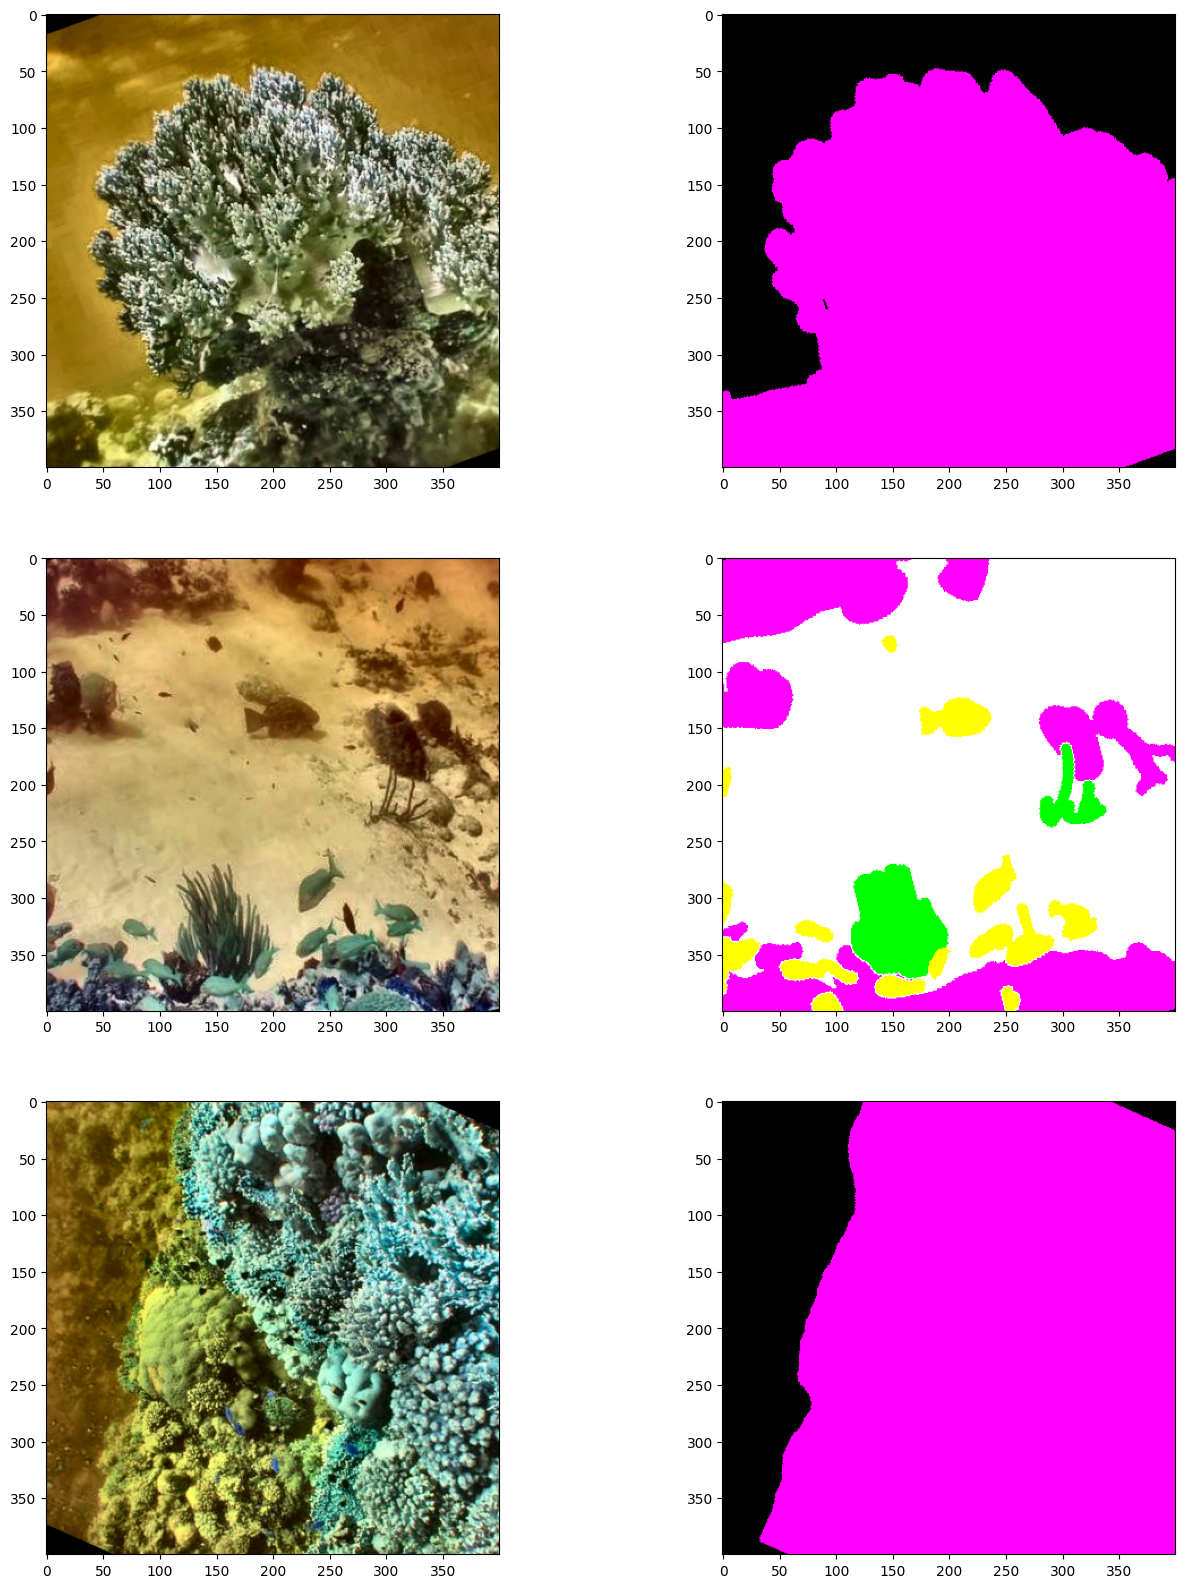

In [ ]:
open_cv_transforms = [clahe, random_rotate]
merged_transformations = transforms.Compose([CenterCrop((400,400))])
image_transformations = transforms.Compose([SimpleNormalize(), ToTensor()])
label_transformations = transforms.Compose([ToTensor()])
example_dataset = UnderwaterDatasetOpenCV(root_dir=train_val_folder, open_cv_transforms=open_cv_transforms, merged_transforms=merged_transformations, input_transforms=image_transformations, label_transforms=label_transformations)

image, label = example_dataset[1]
label = label.detach().cpu().numpy().transpose(1, 2, 0)
image = image.detach().cpu().numpy().transpose(1, 2, 0)

n_pics = 3 
fig, axes = plt.subplots(n_pics,2, figsize=(16,20))
for i in range(n_pics):
    image, label = example_dataset[i]
    label = label.detach().cpu().numpy().transpose(1, 2, 0)
    image = image.detach().cpu().numpy().transpose(1, 2, 0)
    axes[i][0].imshow(image)
    axes[i][1].imshow(label)


In [ ]:
# label_transformations = transforms.Compose([EncodeMask(), ToTensor()])
# example_dataset = UnderwaterDataset(root_dir=train_val_folder, input_transforms=image_transformations, label_transforms=label_transformations)

# counter = np.zeros(8)
# for _, mask in example_dataset:
#     mask=mask.detach().cpu().numpy()
#     for i in range(len(labels)):
#         counter[i] += mask[i, :, :].sum()
# print(counter)

[1.79593248e+08 1.23135990e+07 1.19407880e+07 3.73539940e+07
 2.91769200e+06 1.86100654e+08 3.93095990e+07 7.84153390e+07]


PROPORTIONS [0.32775785 0.02247233 0.02179195 0.06817108 0.00532479 0.33963387
 0.07174006 0.14310807]


(array([3., 2., 0., 0., 1., 0., 0., 0., 0., 2.]),
 array([0.00532479, 0.0387557 , 0.07218661, 0.10561752, 0.13904842,
        0.17247933, 0.20591024, 0.23934115, 0.27277206, 0.30620297,
        0.33963387]),
 <BarContainer object of 10 artists>)

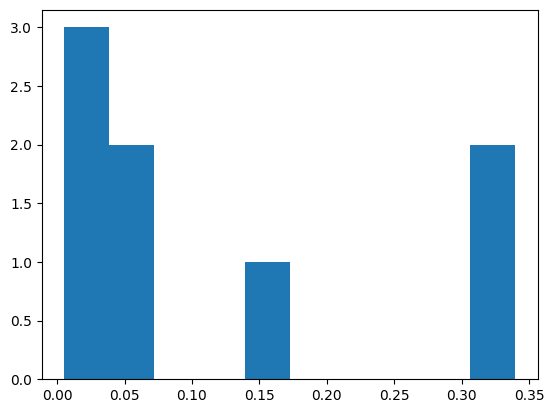

In [ ]:
# counter_sum = counter.sum()
# new_values = counter / counter_sum
# print("PROPORTIONS", new_values)
# plt.hist(new_values)

In [ ]:
proportions = [0.32775785, 0.02247233, 0.02179195, 0.06817108, 0.00532479, 0.33963387, 0.07174006, 0.14310807]

In [ ]:
1/8

0.125

In [ ]:
img, mask = datamodule.train_dataset[0]
print(img.shape, img.dtype)
print(mask.shape, img.dtype)

torch.Size([3, 320, 256]) torch.int64
torch.Size([8, 320, 256]) torch.int64


In [ ]:
import numpy as np

proportions = [0.32775785, 0.02247233, 0.02179195, 0.06817108, 0.00532479, 0.33963387, 0.07174006, 0.14310807]
weights = np.array([(1/len(proportions)) / prop for prop in proportions])
normalized_weights = (weights - min(weights)) / (max(weights) - min(weights))
normalized_weights